## Alumno: Matias Werbin

## Materia: Vision Computer I

## Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `/images` a partir del template `/template`

1.  Obtener una detección del logo en cada imagen sin falsos positivos
2.  Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo témplate del ítem 1
3.  Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

**1) Obtener una detección del logo en cada imagen sin falsos positivos**

<function matplotlib.pyplot.show(close=None, block=None)>

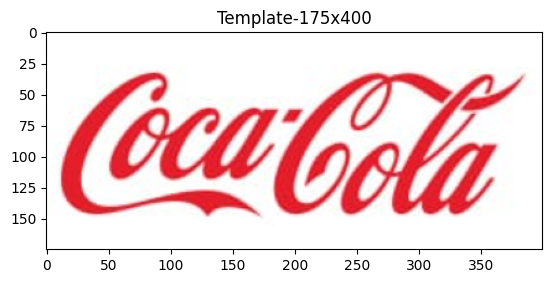

In [2]:
# impresión de template a matchear

template=cv2.imread('template/pattern.png')
template_rgb=cv2.cvtColor(template,cv2.COLOR_BGR2RGB)
plt.imshow(template_rgb)
plt.title(f'Template-{template.shape[0]}x{template.shape[1]}')
plt.show

In [3]:
template_height, template_width = template.shape[:2] 
print(template_height, template_width) # Toda imagen que tenga un tamaño menor en cualquier dimension no podra ser matcheada directamente sin un previo rescalado

175 400


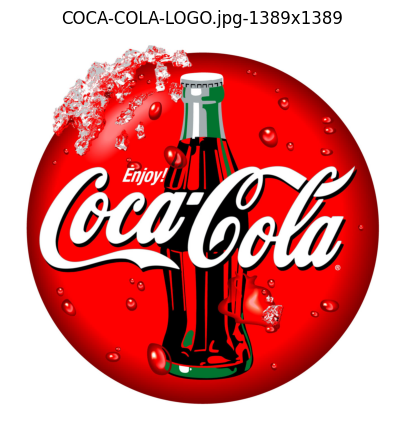

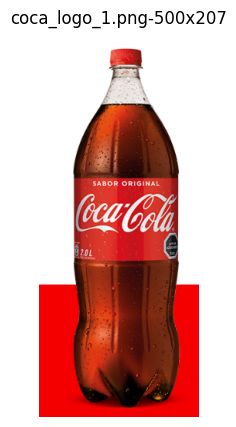

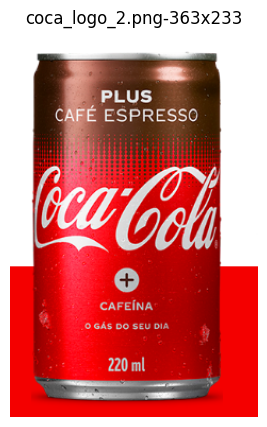

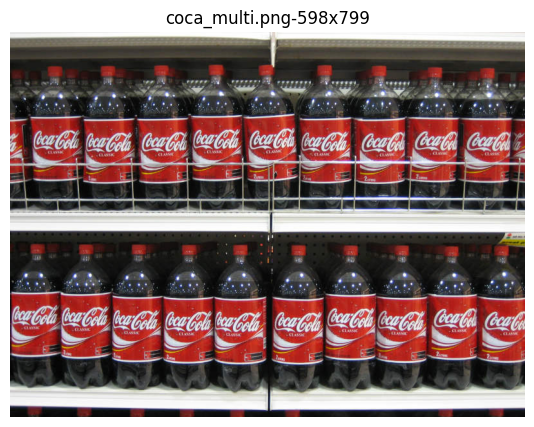

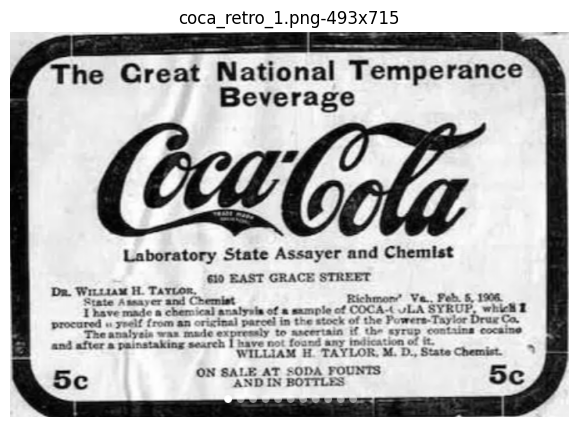

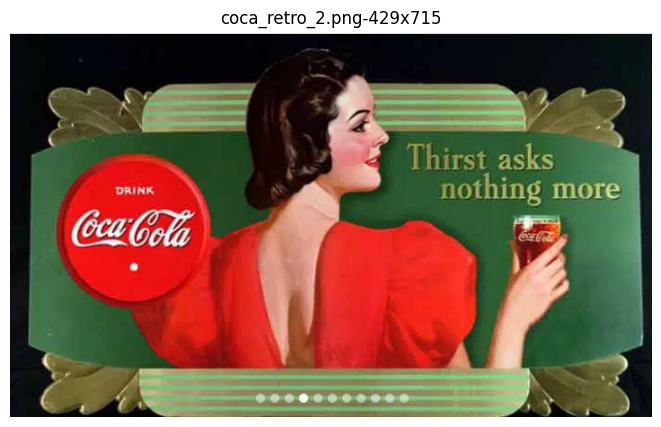

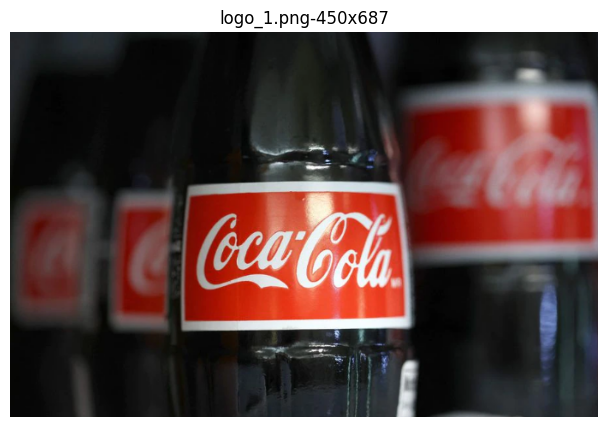

In [4]:
# impresion de imagenes a matchear

folder_path='images'
file_names = os.listdir(folder_path)

for file_name in file_names:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{file_name}-{image.shape[0]}x{image.shape[1]}")
    plt.axis('off')





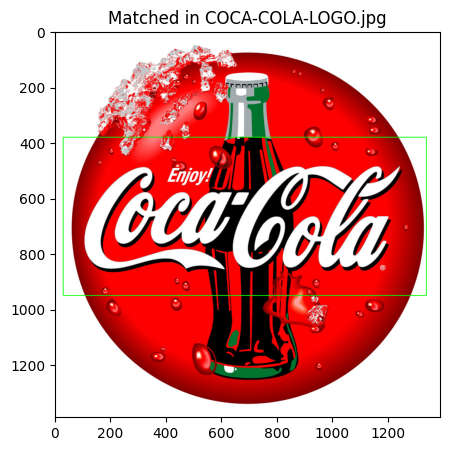

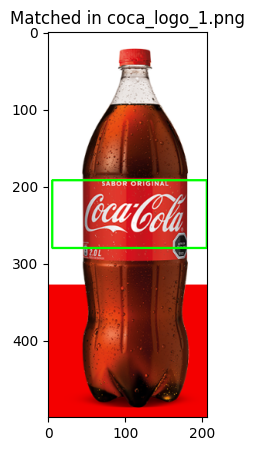

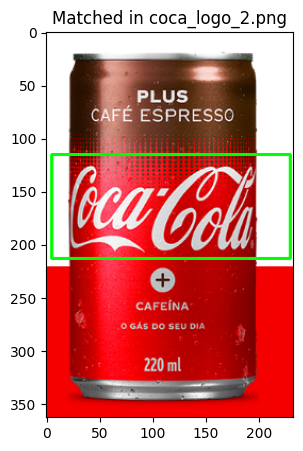

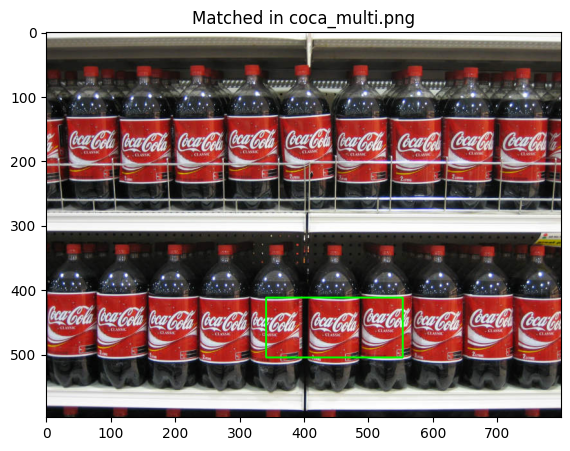

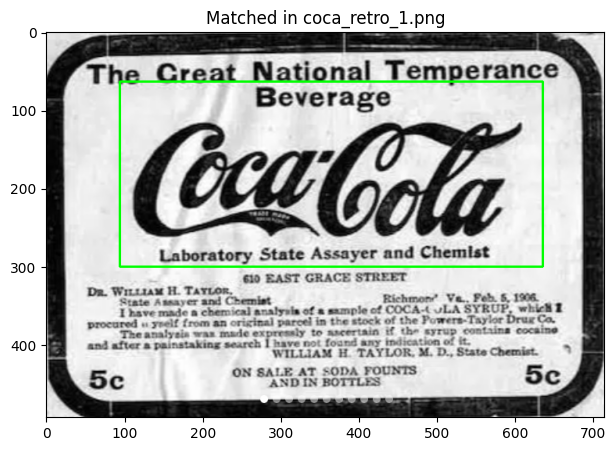

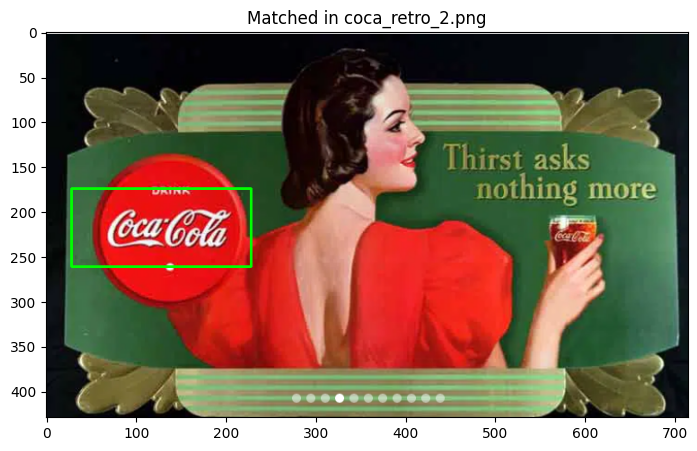

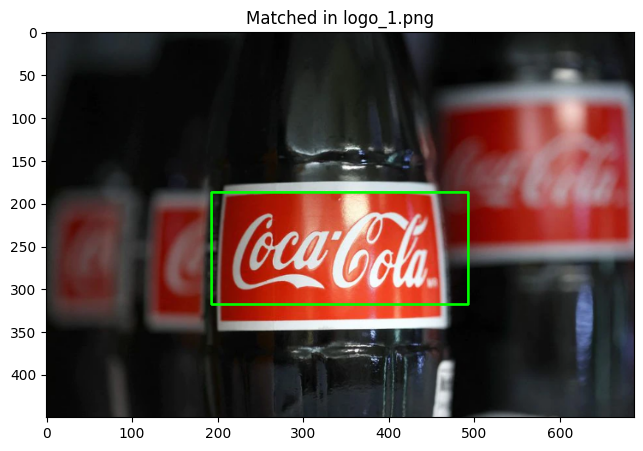

In [5]:
# Leer el template y convertirlo a escala de grises

template = cv2.imread('template/pattern.png', cv2.IMREAD_GRAYSCALE)

# Aplicar el detector de bordes de Canny al template

template_edges = cv2.Canny(template, 50, 150)

# Obtener las dimensiones originales del template

template_height, template_width = template.shape[:2]

folder_path = 'images'
file_names = os.listdir(folder_path)

for file_name in file_names:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)
 
    # Convertir la imagen a escala de grises

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    match_vals = []
    match_locs = []
    match_scales = []

    # Escalar la imagen desde 0.05 a 2 veces su tamaño original

    for scale in np.linspace(0.05, 2, 100)[::-1]:
        new_width = int(image_gray.shape[1] * scale)
        resized = cv2.resize(image_gray, (new_width, int(image_gray.shape[0] * scale)))

        # Si la imagen redimensionada es más pequeña que el template, salir del bucle

        new_h, new_w = resized.shape[:2]
        if new_h < template_height or new_w < template_width:
            break

        # Aplicar el detector de bordes de Canny a la imagen redimensionada

        image_resized_edges = cv2.Canny(resized, 100, 200)

        # Aplicar template matching en las imágenes de bordes redimensionadas

        result = cv2.matchTemplate(image_resized_edges, template_edges, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        match_vals.append(max_val)
        match_locs.append(max_loc)
        match_scales.append(scale)

    # Encontrar la mejor coincidencia (maxima)

    if match_vals:
        idx = np.argmax(match_vals)
        best_scale = match_scales[idx]
        top_left = match_locs[idx]

        # Calcular las coordenadas del rectángulo en la imagen original

        X, Y = np.divide(top_left, best_scale)
        h_src, w_src = template_height / best_scale, template_width / best_scale
        X, Y, Xf, Yf = int(X), int(Y), int(X + w_src), int(Y + h_src)

        # Dibujar un rectángulo en la ubicación encontrada en la imagen original

        cv2.rectangle(image, (X, Y), (Xf, Yf), (0, 255, 0), 2)

        # Mostrar la imagen con el rectángulo dibujado
        
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Matched in {file_name}")
        plt.show()






**2) Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template del ítem 1**

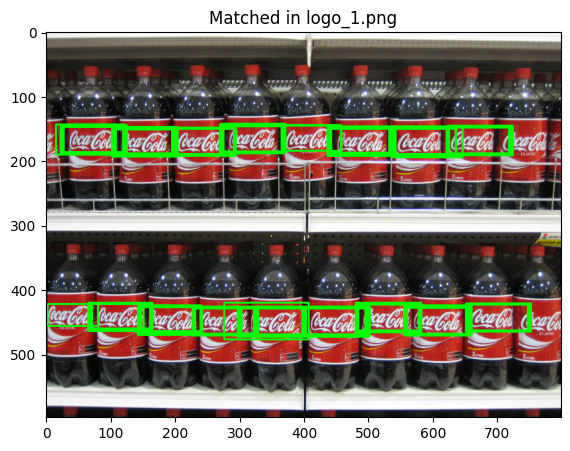

In [6]:
template = cv2.imread('template/pattern.png', cv2.IMREAD_GRAYSCALE)

template_edges = cv2.Canny(template, 50, 150)

template_height, template_width = template.shape[:2]

image = cv2.imread('images/coca_multi.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

match_vals = []
match_locs = []
match_scales = []


 # Escalar la imagen desde 3 a 6 veces su tamaño original 
    
for scale in np.linspace(3, 6, 100)[::-1]:
    new_width = int(image_gray.shape[1] * scale)
    resized = cv2.resize(image_gray, (new_width, int(image_gray.shape[0] * scale)))

     # Si la imagen redimensionada es más pequeña que el template, salir del bucle

    new_h, new_w = resized.shape[:2]
    if new_h < template_height or new_w < template_width:
        break

    # Aplicar el detector de bordes de Canny a la imagen redimensionada
    image_resized_edges = cv2.Canny(resized, 100, 200)

    # Aplicar template matching en las imágenes de bordes redimensionadas
    result = cv2.matchTemplate(image_resized_edges, template_edges, cv2.TM_CCOEFF_NORMED)

    # Umbral para considerar una coincidencia como válida

    threshold = 0.085
    location = np.where(result >= threshold)

    for coord in zip(*location[::-1]):
        match_vals.append(result[coord[1]][coord[0]])
        match_locs.append(coord)
        match_scales.append(scale)

# Cálculo de las posiciones de las múltiples detecciones en la imagen original

for val, loc, scale in zip(match_vals, match_locs, match_scales):
    X, Y = np.divide(loc, scale)
    h_src, w_src = template.shape[0] / scale, template.shape[1] / scale
    X, Y, Xf, Yf = int(X), int(Y), int(X + w_src), int(Y + h_src)

    # Dibujar un rectángulo en la ubicación encontrada en la imagen original
    cv2.rectangle(image, (X, Y), (Xf, Yf), (0, 255, 0), 2)

# Mostrar la imagen con los rectángulos dibujados
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Matched in {file_name}")
plt.show()



**3. Generalizar el algoritmo del item 2 para todas las imágenes.**

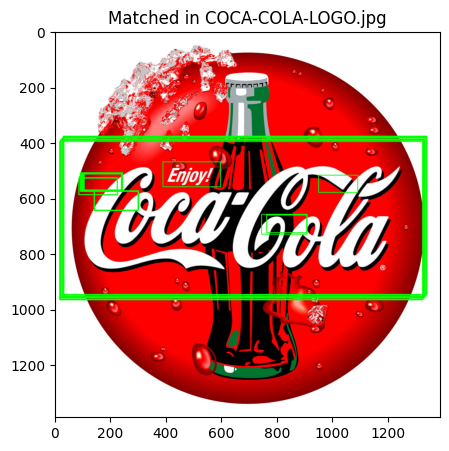

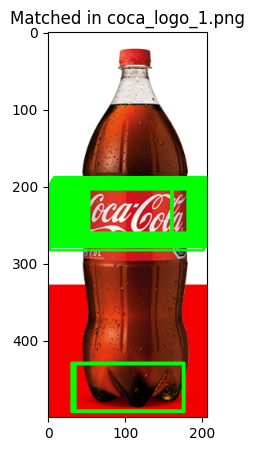

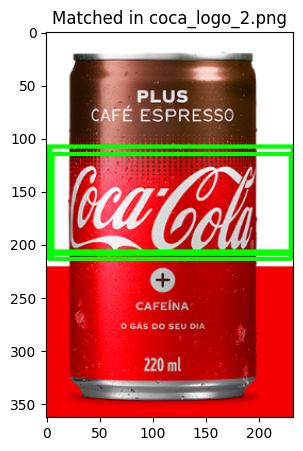

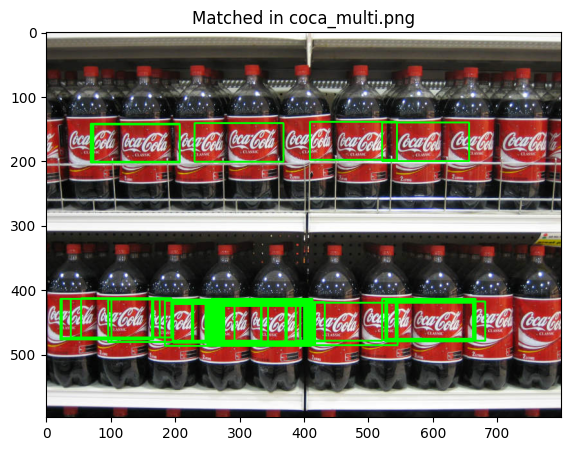

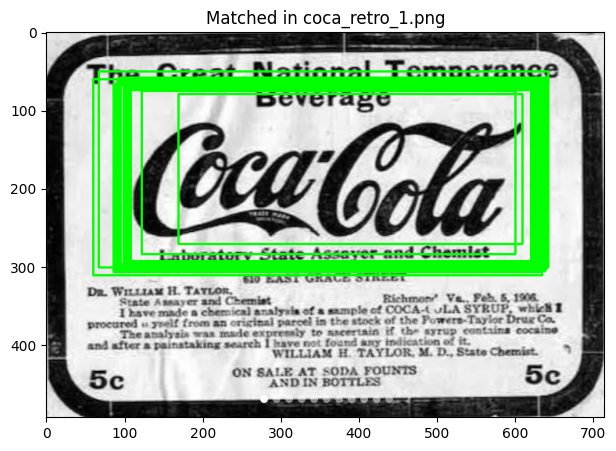

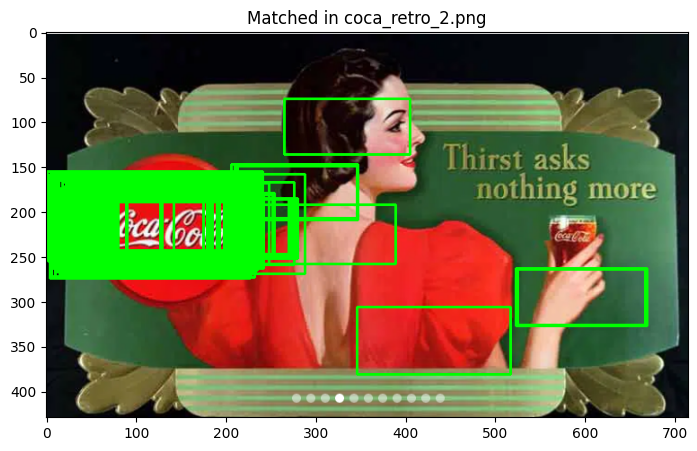

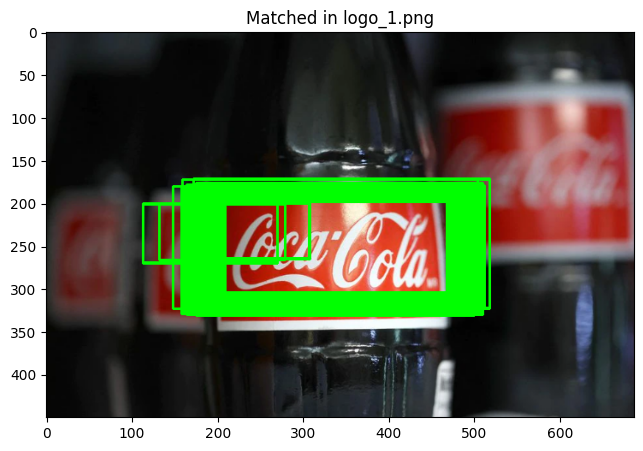

In [7]:
template = cv2.imread('template/pattern.png', cv2.IMREAD_GRAYSCALE)

template_edges = cv2.Canny(template, 50, 150)

template_height, template_width = template.shape[:2]

folder_path = 'images'
file_names = os.listdir(folder_path)

for file_name in file_names:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    match_vals = []
    match_locs = []
    match_scales = []
    

    # Escalar la imagen desde 0.2 a 4 veces su tamaño original
        
    for scale in np.linspace(0.2, 3, 80)[::-1]:
        new_width = int(image_gray.shape[1] * scale)
        resized = cv2.resize(image_gray, (new_width, int(image_gray.shape[0] * scale)))

        # Si la imagen redimensionada es más pequeña que el template, salir del bucle
        
        new_h, new_w = resized.shape[:2]
        if new_h < template_height or new_w < template_width:
            break

        # Aplicar el detector de bordes de Canny a la imagen redimensionada

        image_resized_edges = cv2.Canny(resized, 100, 200)

        # Aplicar template matching en las imágenes de bordes redimensionadas

        result = cv2.matchTemplate(image_resized_edges, template_edges, cv2.TM_CCOEFF_NORMED)

        # Umbrales acotados

        threshold_max = 0.09
        threshold_min = 0.07
        location = np.where((result >= threshold_min) & (result <= threshold_max))

        for coord in zip(*location[::-1]):
            match_vals.append(result[coord[1]][coord[0]])
            match_locs.append(coord)
            match_scales.append(scale)

    # Cálculo de las posiciones de las múltiples detecciones en la imagen original

    for val, loc, scale in zip(match_vals, match_locs, match_scales):
        X, Y = np.divide(loc, scale)
        h_src, w_src = template.shape[0] / scale, template.shape[1] / scale
        X, Y, Xf, Yf = int(X), int(Y), int(X + w_src), int(Y + h_src)
        

        # Dibujar un rectángulo en la ubicación encontrada en la imagen original
        cv2.rectangle(image, (X, Y), (Xf, Yf), (0, 255, 0), 2)

    # Mostrar la imagen con los rectángulos dibujados
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Matched in {file_name}")
    plt.show()

Aunque se logró realizar el matching del template en todas las imágenes, los resultados no son óptimos. En las imágenes con un solo logo, no solo se identificó el template deseado, sino también se detectaron falsos positivos. Por otro lado, en imágenes con múltiples logos, los resultados son un poco más aceptables, ya que logra detectar o aproximarse bastante a los objetivos.

El principal desafío radica en el manejo de los umbrales para determinar el escalado y la ubicación de los cuadros delimitadores en imágenes con tamaños diversos.